# Functions

All of the necessary function definitions and imports are done in this notebook, which is then imported to the other _presentation_ notebooks.

In [38]:
# Some standard import statements

import sys
import os
import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
import time
import decimal
import numpy as np
from scipy.optimize import curve_fit
from IPython import get_ipython
ipython = get_ipython()
ipython.magic('load_ext autoreload')
ipython.magic('autoreload 2')
ipython.magic('matplotlib inline')
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# some data loads to be performed right away
start_time_dict = get_start_times()
p_beam_data_dict = load_all_data(start_time_dict['p_beam'])

# Fitting Functions

In [40]:
def linear_fit(t, N_0, y):
    """function for a linear fit
    
    Arguments:
        t {float} -- time of run
        N_0 {float} -- initial counts at t = 0
        y {float} -- slope of the loss
    
    Returns:
        float -- counts as a function of time; N(t)
    """    
    return N_0 + y * t

# Getting Experimental Start Times

In order to reference meaningful experimental run start times, the reference $t=0$ time must be established. A function that returns a dictionary of relevant start times is implemented for this purpose.

In [14]:
###############################################################################
def get_start_times():
    """Retrieves the UNIX epoch time stamp of various relevant start times
    
    Returns:
        dict: the UNIX epoch time stamps in a dictionary. Key options are:
            'p_beam' - first proton beam current measurement
    """
    
    # initialize the dictionary
    start_time_dict = {}
    
    ## 'p_beam': Proton beam current
    
    # read the 8th of December data as a list of strings
    f = open('../data_p_beam_from_edgard/20171208.csv')
    lines = f.readlines()
    f.close()
    
    # convert the measurement time to epoch time
    date_time = lines[0][0:10] + ' ' + lines[0][11:19]
    pattern = '%Y/%m/%d %H:%M:%S'
    first_p_beam_time = int(time.mktime(time.strptime(date_time, pattern)))
    start_time_dict['p_beam'] = first_p_beam_time
    
    return start_time_dict

# Loading Main Detector Data for a Configuration and Run Type

In [23]:
###############################################################################

def load_data(config, run_type, start_time, norm_dict = None):
    """A function to load data and sum counts for runs of a given
        configuration and pre-storage time
    
    Arguments:
        config {string} -- A string that determines the experimental 
            configuration of the data to be loaded. The options are:
                'NOMI' - nominal, guide-less
                'JPTI' - JP Ti guide with NiP
                'JPSU' - JP SUS guide with NiP
                'DISK' - SS Disk
                'GD01' - UGD01 guide
                'GD03' - UGD03 guide
                'EPSU' - EP SUS guide with NiP
        run_type {string} -- A string that determines what type of data will be 
            loaded. The options are:
                's000' - direct shot measurements 
                's005' - 5 second storage
                's020' - 20 second storage
                's100' - 100 second storage
        start_time {int} -- Unix epoch time stamp of the reference t=0 
            measurement for this data. One should access from the 
            dictionary returned by get_start_times().
        norm_dict {dict} -- dictionary of values of the results from the
            ucn yield analysis. Defaults to None which avoids normalization.
            The key pairs to be used are:
                key 0: run_type {string} -- The options are:
                's000' - direct shot measurements 
                's005' - 5 second storage
                's020' - 20 second storage
                's100' - 100 second storage
                key 1: parameter {string} -- The options are:
                'N_0'     - counts at time 0
                'y'       - loss rate
                'N_0_err' - associated error
                'y_err'   - associated error
    
    Returns:
        numpy.float64 -- An n x 5 data array of the results from loading the
            run data. The number of rows corresponds to the number of runs
            loaded. The five columns are:
                0 - the run start time in seconds since the experimental start
                1 - the storage time (0 if direct shot)
                2 - the number of UCN counts
                3 - sqrt(N) error in number of UCN counts
                4 - [day].[run number] of measurement
    """
        
    # instantiate a new numpy array 
    arr = np.empty((0,5), float)
            
    for filename in os.listdir('../data_main/sorted'):

        # Only the files matching our desired configuration and run 
        # type are selected. The '.tof' condition is just so we 
        # don't perform the analysis twice per run (since it would
        # otherwise match to the .tof and the .txt files)
        if ((config in filename) and (run_type in filename) and 
        ('.tof' in filename)):

            # grab from the text file associated with the run
            f = open( '../data_main/sorted/' + filename[0:22] 
                     + '.txt')  
            lines = f.readlines()
            f.close()

            # grab the epoch time for run start
            date_time = filename[1:3].zfill(2) + '.12.2017 '\
                + lines[26][15:23]
            pattern = '%d.%m.%Y %H:%M:%S'
            run_time = int(time.mktime(
                time.strptime(date_time, pattern)))

            # reset the run_start_time with reference to the
            # t = 0 time
            run_time = run_time - start_time

            # grab the storage time
            storage_time = int(run_type[1:4])

            # The data is retrieved from the .tof file
            count_data = np.loadtxt('../data_main/sorted/' + 
                                    filename[0:22] + '.tof',
                                    usecols = (1))

            # this if/else sequence handles cuts of the data, which for 
            # some runs is specific based on the experimental 
            # conditions
            # !!! These need to be re-documented somewhere in ipynb
            # !!! The eLog parsing needs to be summarized as well
            # specific data cut for run 35 on the 8th
            if ((filename[2:3] == '8') and 
                (filename[10:12] == '35')):

                counts = np.sum(count_data[150:1000])

            # specific data cut for run 66 on the 8th
            elif ((filename[2:3] == '8') and 
                  (filename[10:12] == '66')):

                counts = np.sum(count_data[150:1500])

            # specific data cut for run 88 on the 8th
            elif ((filename[2:3] == '8') and 
                  (filename[10:12] == '88')):

                counts = np.sum(count_data[150:2500])

            # if it is a shot run we take all the counts
            elif (run_type == 's000'):
            
                counts = np.sum(count_data)
            
            # otherwise cut the data normally for a pre-storage run
            # this cuts out the initial background appearing from
            # irradiation
            else 

                counts = np.sum(count_data[150:-1])

            # normalize the data depending on the normalize_flag
            if (norm_dict != None):

                # !!! the error associated with the normalization 
                # routine has not been implemented

                # the fits to the nominal configuration data provide
                # a benchmark for percentage loss of absolute counts
                # depending on the time having elapsed since the start
                # of the experiment. 

                # interpolate on the nominal fit to get a counts value
                # for this run time
                interp_counts = linear_fit(run_time, 
                                           norm_dict[run_type, 'N_0'], 
                                           norm_dict[run_type, 'y'])

                # the interpretation here is that whatever count total 
                # the current run has, it's total counts are actually 
                # this norm_factor of what they would have been without
                # the degradation of the sD2 surface.
                norm_factor = interp_counts / norm_dict[run_type,
                                                        'N_0']

                # this brings the counts back to what they would have 
                # been
                counts = counts / norm_factor

            # saving the [day].[run number] can be useful for debugging
            day_run_no = int(filename[1:3]) + (0.001
                                               * int(filename[9:12]))

            # append the loaded data to the existing array
            arr = np.append(arr, [[run_time,
                                   storage_time,
                                   counts,
                                   np.sqrt(counts),
                                   day_run_no]],
                            axis=0)

    # return the completed array, sorted along the time axis
    return arr[arr[:,0].argsort()]
        
###############################################################################

## Efficiently Loading all Main Detector Data

The idea of this function is to load every data set into a dictionary. For every guide configuration, there are runs of each of the four pre-storage times. There are 7 configurations in total, so this yields 28 data sets. We also want to be able to access every run from each configuration, or every run from each pre-storage time. This amounts to 7 + 4 = 11 additional data sets (plus one more for the 'all', 'all' case). Rather than iteratively reload these every time, they're stored once in a dictionary for later access.

In [27]:
###############################################################################

# !!! some effort to functionalize the smaller, useful parts could be done

def load_all_data(start_time, norm_dict = None):
    """A function to load data and sum counts for individual runs.
    
    Arguments:
        start_time {int} -- Unix epoch time stamp of the reference t=0 
            measurement for this data. One should access from the 
            dictionary returned by get_start_times().
        norm_dict {dict} -- dictionary of values of the results from the
            ucn yield analysis. Defaults to None which avoids normalization.
            The key pairs to be used are:
                key 0: run_type {string} -- The options are:
                's000' - direct shot measurements 
                's005' - 5 second storage
                's020' - 20 second storage
                's100' - 100 second storage
                key 1: parameter {string} -- The options are:
                'N_0'     - counts at time 0
                'y'       - loss rate
                'N_0_err' - associated error
                'y_err'   - associated error
    
    Returns:
        data_dict -- A dictionary of n x 5 data array of the results from 
            loading the run data. The number of rows corresponds to the number 
            of runs loaded. The five columns are:
                0 - the run start time in seconds since the experimental start
                1 - the storage time (0 if direct shot)
                2 - the number of UCN counts
                3 - sqrt(N) error in number of UCN counts
                4 - [day].[run number] of measurement
            The key pairs to be used are:
                key 0: config {string} -- The options are:
                'NOMI' - nominal, guide-less
                'JPTI' - JP Ti guide with NiP
                'JPSU' - JP SUS guide with NiP
                'DISK' - SS Disk
                'GD01' - UGD01 guide
                'GD03' - UGD03 guide
                'EPSU' - EP SUS guide with NiP
                'all'  - all of the above
                key 1: run_type {string} -- The options are:
                's000' - direct shot measurements 
                's005' - 5 second storage
                's020' - 20 second storage
                's100' - 100 second storage
                'all'  - all of the above
    """
    
    # instantiate an empty dictionary
    data_dict = {}

    # instantiate an array for the 'all' 'all' case
    data_dict['all', 'all'] = np.empty((0,5), float)
    
    # instantiate the lists of configurations and run type
    config_list   = ['NOMI', 'JPTI', 'JPSU', 'DISK', 'GD01', 'GD03', 'EPSU']
    run_type_list = ['s000', 's005', 's020', 's100']

    # instantiate all the ['all', run_type] arrays here 
    for run_type in run_type_list:

        data_dict['all', run_type] = np.empty((0,5), float)
    
    # iterate over configurations, run types, and finally runs
    for config in config_list:
        
        # instantiate empty array for the case involving 'all'
        data_dict[config, 'all'] = np.empty((0,5))
        
        for run_type in run_type_list:
            
            # load and save the data for this config and run_type
            data_dict[config, run_type] = load_data(config, 
                                                    run_type, 
                                                    start_time, 
                                                    norm_dict)

            # append to the various conglomerate cases
            data_dict['all', run_type] = np.append(data_dict['all', run_type],
                                                   data_dict[config, run_type], 
                                                   axis = 0)
   
            data_dict[config, 'all'] = np.append(data_dict[config, 'all'], 
                                                 data_dict[config, run_type],
                                                    axis = 0)
   
            data_dict['all', 'all'] = np.append(data_dict['all', 'all'], 
                                                 data_dict[config, run_type],
                                                    axis = 0)
    
    return data_dict
###############################################################################

# sD2 Surface Degradation and UCN Yield

In [this article](https://link.springer.com/article/10.1140/epja/i2018-12594-2), a mechanism is suggested for the observed degradation of the absolute UCN detection rate in measurements at PSI. The following function provides a method for analyzing the degradation of the absolute count data over time.

In [45]:
###############################################################################

def ucn_yield(data_dict, plotting_flag = False):
    """Analyzes the ucn yield over time.
    
    Arguments:
        data_dict {dict} -- A dictionary of n x 5 data array of the results from 
            loading the run data. The number of rows corresponds to the number 
            of runs loaded. The five columns are:
                0 - the run start time in seconds since the experimental start
                1 - the storage time (0 if direct shot)
                2 - the number of UCN counts
                3 - sqrt(N) error in number of UCN counts
                4 - [day].[run number] of measurement
            The key pairs to be used are:
                key 0: config {string} -- The options are:
                'NOMI' - nominal, guide-less
                'JPTI' - JP Ti guide with NiP
                'JPSU' - JP SUS guide with NiP
                'DISK' - SS Disk
                'GD01' - UGD01 guide
                'GD03' - UGD03 guide
                'EPSU' - EP SUS guide with NiP
                'all'  - all of the above
                key 1: run_type {string} -- The options are:
                's000' - direct shot measurements 
                's005' - 5 second storage
                's020' - 20 second storage
                's100' - 100 second storage
                'all'  - all of the above
        plotting_flag {boolean, optional} -- Flag to turn plotting on. 
            Defaults to False.
    
    Returns:
        norm_dict {dict} -- dictionary of values of the results from the
            ucn yield analysis. Defaults to None which avoids normalization.
            The key pairs to be used are:
                key 0: run_type {string} -- The options are:
                's000' - direct shot measurements 
                's005' - 5 second storage
                's020' - 20 second storage
                's100' - 100 second storage
                key 1: parameter {string} -- The options are:
                'N_0'     - counts at time 0
                'y'       - loss rate
                'N_0_err' - associated error
                'y_err'   - associated error
    """
    # list of run types
    run_type_list = ['s000', 's005', 's020', 's100']
    
    # initializing the dictionary to hold the results
    norm_dict = {}
    
    # for colour consistency in plotting
    ax = plt.gca()

    # for counting loop iterations
    text_y_coord = -0.2

    for run_type in run_type_list:
        
        # defining a separate variable for more readable plotting code
        arr = data_dict['NOMI', run_type]

        # for colour consistency in plotting
        color = next(ax._get_lines.prop_cycler)['color']

        # plotting the data by pre-storage time
        plt.errorbar(arr[:,0], arr[:,2], yerr = arr[:,3], fmt = '.',
                     label = run_type, color = color)

        # performing a linear fit
        popt, pcov = curve_fit(linear_fit, arr[:,0], arr[:,2], 
                               sigma = arr[:,3], absolute_sigma = True)
        plt.plot(arr[:,0], linear_fit(arr[:,0], *popt), color = color);

        # saving the fit results to the dictionary
        norm_dict[run_type, 'N_0']     = popt[0]
        norm_dict[run_type, 'y']       = popt[1]
        norm_dict[run_type, 'N_0_err'] = np.sqrt(np.diag(pcov))[0]
        norm_dict[run_type, 'y_err']   = np.sqrt(np.diag(pcov))[1]

        # printing the fit results below the figure
        text_y_coord = text_y_coord - 0.1
        plt.text(0, text_y_coord, run_type 
                 + r': $N_0 = $%.2e $\pm $ %.2e$, \quad \gamma_{sD_2} = $%.2e $ \pm $ %.2e' % (
                     decimal.Decimal(norm_dict[run_type, 'N_0']), 
                     decimal.Decimal(norm_dict[run_type, 'y']),
                     decimal.Decimal(norm_dict[run_type, 'N_0_err']), 
                     decimal.Decimal(norm_dict[run_type, 'y_err'])),
                 transform=ax.transAxes);

    # presentation stuff
    plt.yscale('log')
    plt.xlabel('Time Elapsed [s]');
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.ylabel('UCN Counts');
    plt.legend();
    plt.title('Nominal Configuration - Main Detector');
    
    return norm_dict

###############################################################################

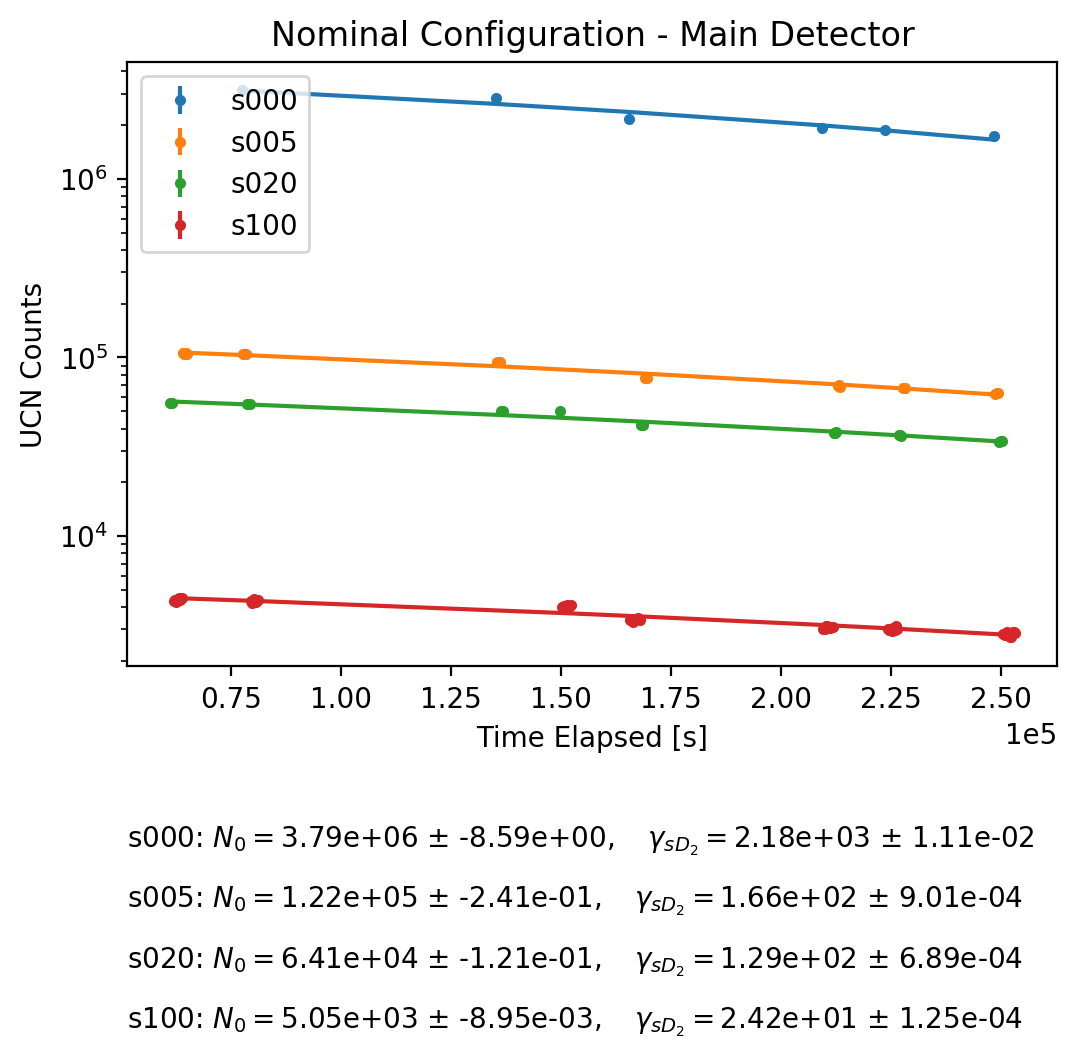

In [47]:
ucn_yield(p_beam_data_dict, True);


The proton beam current data is located in a series of csv files, which are loaded into a single array by the function below.

In [58]:
###############################################################################

def load_p_beam_data(start_time):
    """Loads all of the proton beam data into an array
    
    Arguments:
        start_time {int} -- Unix epoch time stamp of the reference t=0 
            measurement for this data. One should access from the 
            dictionary returned by get_start_times().
    
    Returns:
        p_beam_data (numpy.float64): a (2 x n) array of all of the proton beam 
            monitoring data. 
                - row 0: time elapsed in seconds since the first measurement
                - row 1: beam current in uA
    """
    
    # instantiate array to hold the resulting data, empty and single column 
    # at first, for data to be successively stacked
    p_beam_data = np.empty((2,0), float)
    
    # loop through the files and load the data
    for filename in os.listdir('../data_p_beam_from_edgard'):
        
        # all of the csv file is converted to a list of strings for extracting
        # the time data
        f = open('../data_p_beam_from_edgard/' + filename)
        lines = f.readlines()
        f.close()
        
        # instantiate an array to hold the measurement times
        times = np.zeros(np.shape(lines)[0])
        
        # loop over every row in the csv file
        for i in range(0, np.shape(lines)[0]):
            
            # convert the measurement time to epoch time
            date_time = lines[i][0:10] + ' ' + lines[i][11:19]
            pattern = '%Y/%m/%d %H:%M:%S'
            measurement_time = int(
                time.mktime(time.strptime(date_time, pattern)))
            
            # save the elapsed time to the times array
            times[i] = measurement_time - start_time
        
        # the current data is loaded into a numpy array
        data = np.loadtxt('../data_p_beam_from_edgard/' + filename, 
                          delimiter = '\t', usecols=(2));
        
        # append the time and count data to the array
        p_beam_data = np.append(p_beam_data, 
                                np.vstack((times, data)), 
                                axis = 1)
        
    return p_beam_data

###############################################################################

In [57]:
p_beam_data = load_p_beam_data(start_time_dict['p_beam'])

(2, 0)
(2, 43200)
(2, 43200)
(2, 43200)
(2, 86400)
(2, 43200)
(2, 129600)
(2, 43200)
(2, 172800)
(2, 43200)
